In [1]:
import os
import socket
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
country_code = "CO"
print('Country:', country_code)

Country: CO


In [3]:
# Local
print('Hostname:', socket.gethostname())
if  'samuel' in socket.gethostname().lower():
    path_to_data='../../data'
# Cluster
else:
    path_to_data='/scratch/spf248/twitter/data'
    
path_to_counts=os.path.join(path_to_data,'timelines','counts')
path_to_mentions=os.path.join(path_to_data,'mentions')
path_to_keywords=os.path.join(path_to_data,'keywords','labor')
path_to_official_data=os.path.join(path_to_data,'official')
print(path_to_mentions)
print(path_to_official_data)

Hostname: Samuels-MacBook-Pro.local
../../data/mentions
../../data/official


# Twitter Labor Market Indicators

In [4]:
wordlists=pd.DataFrame()
for file in glob(os.path.join(path_to_keywords,country_code,country_code+'*')):
    targets=pd.read_csv(file,squeeze=True,header=None).sort_values().reset_index(drop=True).rename('target').to_frame()
    targets['wordlist']=re.findall('-([a-z]+).',file)[0]
    wordlists=pd.concat([wordlists,targets.reset_index()])
wordlists=wordlists.sort_values(by=['wordlist','index']).set_index(['wordlist','index'])['target']

In [5]:
wordlists.tail()

wordlist    index
unemployed  39        Sigo sin chamba
            40        Sigo sin empleo
            41        Sigo sin laburo
            42        Sigo sin puesto
            43       Sigo sin trabajo
Name: target, dtype: object

In [6]:
print('Import Mentions Counts')
start = timer()

mentions=pq.ParquetDataset(glob(os.path.join(path_to_mentions,country_code,'*.parquet'))).read().to_pandas()
print('# obs:', mentions.shape[0])

print("Done in", round(timer()-start), "sec")

Import Mentions Counts
# obs: 110669
Done in 5 sec


In [7]:
mentions.filter(regex='n_').sum().sort_values(ascending=False).head(20)

n_users            27944336
n_offer               20465
n_offer-1             11962
n_search              11478
n_offer-10             7379
n_unemployed           4445
n_search-82            3201
n_search-52            3086
n_search-55            2670
n_unemployed-26        2247
n_search-81            1334
n_offer-0              1203
n_hire                 1193
n_hire-34               939
n_offer-2               903
n_loss                  863
n_unemployed-11         729
n_unemployed-5          631
n_offer-3               572
n_search-54             470
dtype: int64

In [8]:
mentions.head()

,year,month,user_location,n_search-8,n_hire-41,n_hire-25,n_hire-40,n_unemployed-23,n_search-21,n_unemployed-34,...,n_search-29,n_loss-78,n_unemployed-6,n_loss-96,n_hire-9,n_offer-1,n_loss-111,n_search,n_unemployed-25,n_loss-49
0,2011,9,"Cali, Colombia",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012,1,Barranquilla,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,2012,8,"Manizales, Caldas",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013,1,medellin,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2013,5,ibague,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [9]:
mentions.rename(
columns=lambda x:'n_'+re.findall('([a-z]+)-(\d+)',x)[0][0]+'-'+\
wordlists.loc[re.findall('([a-z]+)-(\d+)',x)[0][0]][int(re.findall('([a-z]+)-(\d+)',x)[0][1])] if '-' in x else x,inplace=True)

In [10]:
mentions.head()

,year,month,user_location,n_search-Adjunto mi hoja de vida,n_hire-comienzo un nuevo empleo,n_hire-Quieren que empiece mi camello mañana,n_hire-acabo de firmar para un nuevo camello,n_unemployed-No tengo chamba,n_search-Estoy aplicando a ofertas de trabajo,n_unemployed-Ojalá tuviera un laburo,...,n_search-Estoy enviando mi hoja de vida,n_loss-Me salieron del camello hoy,n_unemployed-Estoy sin camello,n_loss-hoy perdi mi camello,n_hire-Hoy consegui un camello,n_offer-#trabajosihay,n_loss-me corrieron hoy,n_search,n_unemployed-No tengo laburo,n_loss-Hoy me salieron del laburo
0,2011,9,"Cali, Colombia",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012,1,Barranquilla,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,2012,8,"Manizales, Caldas",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013,1,medellin,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2013,5,ibague,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


# Twitter Account Locations Geocoded

In [11]:
locations=pd.read_pickle(os.path.join(path_to_data,'locations','profiles','account-locations.pkl'))

locations=locations[
locations.country_short==country_code].drop(
['n_users','latitude','longitude'],1).reset_index(drop=True)

In [12]:
locations.head()

,user_location,country_long,country_short,locality_long,locality_short,administrative_area_level_1_long,administrative_area_level_1_short,administrative_area_level_2_long,administrative_area_level_2_short
0,Colombia,Colombia,CO,NaN,NaN,NaN,NaN,NaN,NaN
1,colombia,Colombia,CO,NaN,NaN,NaN,NaN,NaN,NaN
2,Bogota,Colombia,CO,Bogotá,Bogotá,Bogota,Bogota,NaN,NaN
3,Bogotá,Colombia,CO,Bogotá,Bogotá,Bogota,Bogota,NaN,NaN
4,"Bogotá, Colombia",Colombia,CO,Bogotá,Bogotá,Bogota,Bogota,NaN,NaN


# Labor Market Statistics

In [13]:
surveys=pd.read_csv(os.path.join(path_to_official_data,'surveys',country_code+'.csv'))

In [14]:
surveys.head()

,Quarter,year,quarter,month,administrative_area_level_1,urban_or_rural,unemployed,employed
0,Q01,2013,Q01,1,5,Rural,4.727841,51.528511
1,Q01,2013,Q01,1,8,Rural,1.274374,49.108513
2,Q01,2013,Q01,1,13,Rural,2.608287,44.270412
3,Q01,2013,Q01,1,15,Rural,4.896174,47.915134
4,Q01,2013,Q01,1,17,Rural,6.603644,52.226334


In [15]:
aggregates=pd.read_csv(os.path.join(path_to_official_data,'aggregates','monthly.csv'))
aggregates=aggregates[['date',country_code]].copy()
aggregates['year']=aggregates['date'].map(lambda x:pd.to_datetime(x).year)
aggregates['month']=aggregates['date'].map(lambda x:pd.to_datetime(x).month)
aggregates.rename(columns={country_code:'unemployment'},inplace=True)
aggregates.drop('date',1,inplace=True)

In [16]:
aggregates.head()

,unemployment,year,month
0,14.6,2010,1
1,12.6,2010,2
2,11.8,2010,3
3,12.2,2010,4
4,12.0,2010,5


# Country-level Time Series

In [17]:
df=pd.merge(mentions,locations[['user_location']]).drop('user_location',1)
df=df.groupby(['year','month'],as_index=False).sum()
df.year=df.year.astype(int)
df.month=df.month.astype(int)
df.sort_values(by=['year','month'],inplace=True)
df=pd.merge(aggregates,df)
df['date']=df[['year','month']].apply(lambda x:'-'.join([str(y) for y in x]),1)
df=pd.concat([df.filter(regex='n_').drop('n_users',1).divide(
df.n_users,axis=0).rename(columns=lambda x:x.replace('n_','pct_'))*100,
df.drop(df.drop('n_users',1).filter(regex='n_').columns,1).drop(['year','month'],1)],1)

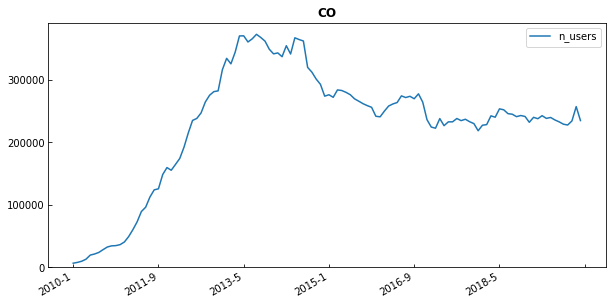

In [18]:
fig,ax=plt.subplots(figsize=(10,5))
df.plot(ax=ax,y='n_users',x='date',style='-',markersize=2)
ax.set_xlabel('')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
ax.set_title(country_code,fontweight='bold')
ax.locator_params(axis='y',nbins=5)
ax.set_ylim([0,df.n_users.max()*1.05])
fig.autofmt_xdate()

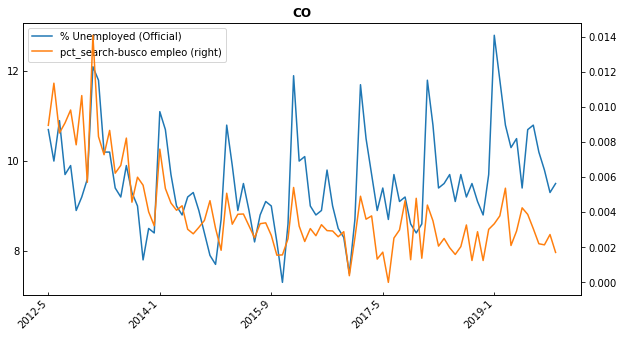

In [29]:
label='pct_search-busco empleo'
fig,ax=plt.subplots(figsize=(10,5))
df.iloc[28:].plot(ax=ax,y='unemployment',x='date',label='% Unemployed (Official)')
df.iloc[28:].plot(ax=ax,y=label,secondary_y=True,x='date',label=label)
ax.set_xlabel('')
ax.tick_params(which='both',direction='in',pad=3)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right')
ax.set_title(country_code,fontweight='bold')
ax.locator_params(axis='y',nbins=6)
plt.savefig(os.path.join(path_to_data,'../fig/'+country_code+'-'+label+'.pdf'),bbox_inches='tight')

In [26]:
df.iloc[30:].corr()['unemployment'].dropna().sort_values().tail(20)

pct_search-Estoy en búsqueda de trabajo    0.293348
pct_offer-Enviar su CV                     0.303892
pct_search-Envié mi CV                     0.310542
pct_unemployed-Estoy sin trabajo           0.312889
pct_search-Alguien sabe de trabajos        0.326103
pct_search-Necesito un trabajo             0.341265
pct_search-Necesito encontrar trabajo      0.357806
pct_search-busco trabajo                   0.363945
pct_unemployed                             0.399415
pct_search-busco empleo                    0.405262
pct_hire                                   0.408168
pct_search                                 0.416351
pct_search-Adjunto mi hoja de vida         0.437055
pct_search-Adjunto mi hoja de vida         0.437055
pct_search-Adjunto mi hoja de vida         0.437055
pct_search-Adjunto mi hoja de vida         0.437055
pct_unemployed-Estoy desempleado           0.468033
pct_hire-Ya tengo trabajo                  0.487833
pct_offer-Oferta laboral                   0.536909
unemployment

In [20]:
df.iloc[30:].filter(regex='search').corr().stack().sort_values().where(lambda x:x<1).dropna().tail(10)

pct_search                     pct_search-Necesito un empleo    0.750860
pct_search-Necesito un empleo  pct_search                       0.750860
pct_search                     pct_search-busco empleo          0.762814
pct_search-busco empleo        pct_search                       0.762814
pct_search-Necesito trabajo    pct_search                       0.811045
pct_search                     pct_search-Necesito trabajo      0.811045
pct_search-busco empleo        pct_search-busco trabajo         0.851806
pct_search-busco trabajo       pct_search-busco empleo          0.851806
                               pct_search                       0.858274
pct_search                     pct_search-busco trabajo         0.858274
dtype: float64

# County-level Estimates

In [21]:
# df=pd.merge(
# mentions,
# locations[
# ['user_location','administrative_area_level_1_short','administrative_area_level_2_long']
# ]).drop('user_location',1).rename(columns=lambda x:x.replace('_short','').replace('_long',''))

# df=df.groupby(['year','month','administrative_area_level_1','administrative_area_level_2'],as_index=False).sum()

# df.year=df.year.astype(int)
# df.month=df.month.astype(int)

# df=pd.merge(df,surveys.drop(['quarter','employed','urban_or_rural'],1),
# on=['year','month','administrative_area_level_1','administrative_area_level_2'])

# df.sort_values(by=['year','month'],inplace=True)